# TODO:
1. Tune resnet feature extractor for 64x64 cifar10 images
1. Build custom image-preprocessing function to not rely on kerases one
1. Check what preprocessing has to be in place for opencv imread()

https://pyimagesearch.com/2019/06/24/change-input-shape-dimensions-for-fine-tuning-with-keras/

# Load train and test data

In [1]:
import numpy as np
from pathlib import Path
from sklearn.utils import Bunch
import cv2 as cv

def load_image_files(images_dir_path, test_size=0.2, target_size=(224, 224),):
    images_dir = Path(images_dir_path)
    directories = [directory for directory in images_dir.iterdir()]
    classes = [class_directory.name.lower() for class_directory in directories]

    train_data = []
    test_data = []

    for class_index, directory in enumerate(directories):
        class_images_cnt = 0
        for file in directory.iterdir():
            class_images_cnt += 1

        test_size_cnt = int(class_images_cnt * test_size)
        for i, file in enumerate(directory.iterdir()):
            # image = imread(file)
            # image_data = resize(image, dimension, anti_aliasing=True, mode='reflect')
            # # image_data = np.asarray(image_data).transpose((2, 0, 1))
            # # image_data = image_data[np.newaxis, :3, :, :] / 255.0
            # image_data = image_data.astype(np.float32)

            # image_normalized = image / 255.0
            # image_normalized = (image_normalized - [0.485, 0.456, 0.406]) / [0.229, 0.224, 0.225]

            image = cv.imread(file.as_posix(), cv.IMREAD_COLOR)
            image = cv.resize(image, target_size)
            image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
            image_data = image - [103.939, 116.779, 123.68]

            batch = Bunch(
                image=image,
                image_data=image_data,
                class_index=class_index,
                class_name=classes[class_index],
            )

            if i < test_size_cnt:
                test_data.append(batch)
                continue

            train_data.append(batch)

    return train_data, test_data


train_dataset, test_dataset = load_image_files("groceries", target_size=(224, 224))
# image_dataset = load_image_files("cifar-10", dimension=(64, 64))

print("image-data shape:", np.shape(train_dataset[0].image_data))
print("image-data min:", min(map(lambda x: x.image_data.min(), train_dataset)))
print("image-data max:", max(map(lambda x: x.image_data.max(), test_dataset)))
print("train-dataset size:", len(train_dataset))
print("test-dataset size:", len(test_dataset))

image-data shape: (224, 224, 3)
image-data min: -123.68
image-data max: 151.061
train-dataset size: 3967
test-dataset size: 980


# Render sample train image

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

random_index = np.random.randint(len(train_dataset))

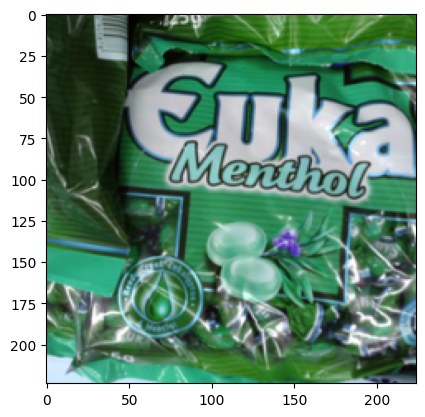

In [3]:
plt.imshow(train_dataset[random_index].image.astype(int))
plt.show()

# Extract train and test data from batches

In [4]:
import numpy as np

x_train = np.asarray(list(map(lambda batch: batch.image_data, train_dataset)))
y_train_raw = np.asarray(list(map(lambda batch: batch.class_index, train_dataset)))
x_test = np.asarray(list(map(lambda batch: batch.image_data, test_dataset)))
y_test_raw = np.asarray(list(map(lambda batch: batch.class_index, test_dataset)))

# Plot train dataset distribution among classes

(array([318., 330., 412., 372., 280., 617., 348., 494., 386., 410.]),
 array([ 0. ,  2.4,  4.8,  7.2,  9.6, 12. , 14.4, 16.8, 19.2, 21.6, 24. ]),
 <BarContainer object of 10 artists>)

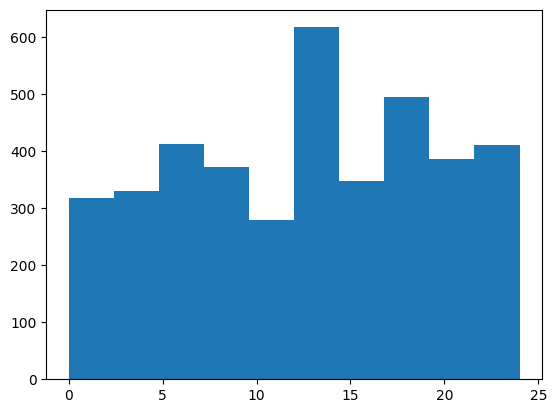

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.hist(y_train_raw)

# Load resnet50 trained on imagenet from keras

In [6]:
from keras.applications.resnet50 import ResNet50

resnet_model = ResNet50(weights="imagenet")
resnet_model.summary()

Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 25,636,712 (97.80 MB)

 Trainable params: 25,583,592 (97.59 MB)

 Non-trainable params: 53,120 (207.50 KB)

# Test raw resnet50 works as expected

In [7]:
y_pred = resnet_model.predict(x_test)
print("y_pred max:", max(y_pred[0]))
print("y_pred min:", min(y_pred[0]))

31/31 ━━━━━━━━━━━━━━━━━━━━ 21s 644ms/step
y_pred max: 0.93884283
y_pred min: 3.4192475e-12


# Preprocess train and test data for resnet50 transfer learning and model fitting

In [8]:
from keras.applications.resnet50 import preprocess_input

preprocessed1 = preprocess_input(train_dataset[1].image)
preprocessed2 = train_dataset[1].image_data

print(preprocessed1[50][50])
print(preprocessed2[50][50])

print(preprocessed1.shape)
print(preprocessed2.shape)


[-53.939003 -28.779    -60.68    ]
[-53.939 -28.779 -60.68 ]
(224, 224, 3)
(224, 224, 3)


In [9]:
from keras.applications.resnet50 import preprocess_input

x_train_preprocessed = preprocess_input(np.asarray(list(map(lambda x: x.image, train_dataset))))
x_test_preprocessed = preprocess_input(np.asarray(list(map(lambda x: x.image, test_dataset))))

In [10]:
print(x_train[0][0][0])
print(x_train_preprocessed[0][0][0])

[24.061 11.221  4.32 ]
[24.060997  11.221001   4.3199997]


# Build feature extractor from resnet by removing last dense and softmax layers

In [11]:
import keras

# Build a new model that is ResNet50 minus the very last layer
avg_pool_layer = resnet_model.get_layer("avg_pool")
resnet_layers = keras.Model(inputs=resnet_model.inputs, outputs=avg_pool_layer.output)
resnet_layers.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 23,534,592 (89.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

# Extract features with resnet50 layers

In [12]:
# We use our resnet to "predict" but because we have removed the top layer, 
# this outputs the activations of the second to last layer on our dataset

x_train_features = resnet_layers.predict(x_train_preprocessed)
x_test_features = resnet_layers.predict(x_test_preprocessed)

124/124 ━━━━━━━━━━━━━━━━━━━━ 175s 1s/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 87s 3s/step


In [15]:
x_train_features1 = resnet_layers.predict(x_train)
x_test_features1 = resnet_layers.predict(x_test)

124/124 ━━━━━━━━━━━━━━━━━━━━ 289s 2s/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 20s 649ms/step


In [17]:
diff = x_train_features - x_train_features1
print(np.min(diff), np.max(diff))

diff = x_train_features - x_train_features1
print(np.min(diff), np.max(diff))

-7.748604e-06 1.1920929e-05
-7.748604e-06 1.1920929e-05


# Save resnet50 feature extractor to .onnx

In [18]:
import numpy as np
import tensorflow as tf
import tf2onnx
import onnx
import onnxruntime as rt

input_signature = [tf.TensorSpec([1, 224, 224, 3], tf.double, name='x')]
resnet_layers.output_names=['output']

onnx_model, _ = tf2onnx.convert.from_keras(resnet_layers, input_signature, opset=13)
onnx.save(onnx_model, "resnet50_feature_extractor_groceries_224_224_3.onnx")

session = rt.InferenceSession("resnet50_feature_extractor_groceries_224_224_3.onnx", providers=["CPUExecutionProvider"])
input_name = session.get_inputs()[0].name

test_sample = x_test[0]
test_sample_bulk = np.array([test_sample.astype(np.float64)])
onx_features = session.run(None, {input_name: test_sample_bulk})[0][0]
rs50_features = resnet_layers.predict(test_sample_bulk)[0]

print("onx shape:", onx_features.shape)
print("rs50 shape:", rs50_features.shape)
print("length onx, rs50 diff:", len(onx_features) - len(rs50_features))
print("max onx, rs50 diff:", max(onx_features - rs50_features))
print("min onx, rs50 diff:", min(onx_features - rs50_features))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
onx shape: (2048,)
rs50 shape: (2048,)
length onx, rs50 diff: 0
max onx, rs50 diff: 4.7683716e-06
min onx, rs50 diff: -7.6293945e-06


# Learn SVM on features extracted

In [20]:
import cv2

svm = cv2.ml.SVM_create()
svm.setType(cv2.ml.SVM_C_SVC)
svm.setKernel(cv2.ml.SVM_LINEAR)
svm.setTermCriteria((cv2.TERM_CRITERIA_MAX_ITER, 500, 1e-6))
svm.train(x_train_features1.astype(np.float32), cv2.ml.ROW_SAMPLE, y_train_raw)

True

In [22]:
from sklearn.metrics import classification_report

y_pred = svm.predict(x_test_features)[1]
print(classification_report(y_test_raw, y_pred))

              precision    recall  f1-score   support

           0       0.76      0.83      0.79        23
           1       0.78      0.67      0.72        21
           2       0.61      0.52      0.56        33
           3       0.82      0.96      0.88        52
           4       0.66      0.77      0.71        30
           5       0.70      0.64      0.67        36
           6       0.67      0.53      0.59        34
           7       0.77      0.72      0.74        32
           8       0.75      0.68      0.71        31
           9       0.74      0.70      0.72        61
          10       0.81      0.49      0.61        35
          11       0.73      0.47      0.57        34
          12       0.74      0.91      0.82        56
          13       0.83      0.92      0.87        37
          14       0.80      0.85      0.82        60
          15       0.79      0.71      0.75        59
          16       0.86      0.89      0.87        27
          17       0.81    

In [23]:
svm.save("cnn_svm_groceries_37632_f32.dat")

In [24]:
# svm = cv2.ml.SVM_load("svm_cifar10_12544_f32.dat")
svm = cv2.ml.SVM_load("cnn_svm_groceries_37632_f32.dat")
y_pred = svm.predict(x_test_features1.astype(np.float32))[1]

In [25]:
from sklearn.metrics import classification_report

y_pred = svm.predict(x_test_features)[1]
print(classification_report(y_test_raw, y_pred))

              precision    recall  f1-score   support

           0       0.76      0.83      0.79        23
           1       0.78      0.67      0.72        21
           2       0.61      0.52      0.56        33
           3       0.82      0.96      0.88        52
           4       0.66      0.77      0.71        30
           5       0.70      0.64      0.67        36
           6       0.67      0.53      0.59        34
           7       0.77      0.72      0.74        32
           8       0.75      0.68      0.71        31
           9       0.74      0.70      0.72        61
          10       0.81      0.49      0.61        35
          11       0.73      0.47      0.57        34
          12       0.74      0.91      0.82        56
          13       0.83      0.92      0.87        37
          14       0.80      0.85      0.82        60
          15       0.79      0.71      0.75        59
          16       0.86      0.89      0.87        27
          17       0.81    

# Train simple perceptron on features extracted

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical

feature_model = Sequential()
feature_model.add(Dense(25, activation="sigmoid"))
feature_model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

hist = feature_model.fit(
    x_train_features,
    to_categorical(y_train_raw),
    epochs=50,
    validation_data=(
        x_test_features,
        to_categorical(y_test_raw)
    )
)

Epoch 1/50


124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.3314 - loss: 2.4326 - val_accuracy: 0.6531 - val_loss: 1.1280
Epoch 2/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 675us/step - accuracy: 0.7579 - loss: 0.8620 - val_accuracy: 0.7092 - val_loss: 0.9579
Epoch 3/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 679us/step - accuracy: 0.8575 - loss: 0.5472 - val_accuracy: 0.7480 - val_loss: 0.8437
Epoch 4/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 663us/step - accuracy: 0.9123 - loss: 0.3823 - val_accuracy: 0.7653 - val_loss: 0.7866
Epoch 5/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 680us/step - accuracy: 0.9495 - loss: 0.2913 - val_accuracy: 0.7857 - val_loss: 0.7459
Epoch 6/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 654us/step - accuracy: 0.9645 - loss: 0.2337 - val_accuracy: 0.7867 - val_loss: 0.7093
Epoch 7/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 683us/step - accuracy: 0.9798 - loss: 0.1818 - val_accuracy: 0.7969 - val_loss: 0.7075
Epoch 8/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 682us/step - accuracy: 0.9884 - loss: 0.1440 - val_accuracy:

In [ ]:
from sklearn.metrics import classification_report

y_pred = feature_model.predict(x_test_features)
y_pred_argmaxed = np.asarray(list(map(lambda x: np.argmax(x), y_pred)))

print("Classification report for - \n{}:\n{}\n".format(
    feature_model, classification_report(y_test_raw, y_pred_argmaxed)
))

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 385us/step


Classification report for - 
<Sequential name=sequential, built=True>:
              precision    recall  f1-score   support

           0       0.88      0.65      0.75        23
           1       0.78      0.67      0.72        21
           2       0.72      0.55      0.62        33
           3       0.84      0.92      0.88        52
           4       0.76      0.87      0.81        30
           5       0.81      0.72      0.76        36
           6       0.86      0.56      0.68        34
           7       0.73      0.75      0.74        32
           8       0.77      0.77      0.77        31
           9       0.80      0.74      0.77        61
          10       0.85      0.49      0.62        35
          11       0.87      0.76      0.81        34
          12       0.79      0.93      0.85        56
          13       0.92      0.95      0.93        37
          14       0.76      0.87      0.81        60
          15       0.84      0.90      0.87        59
          

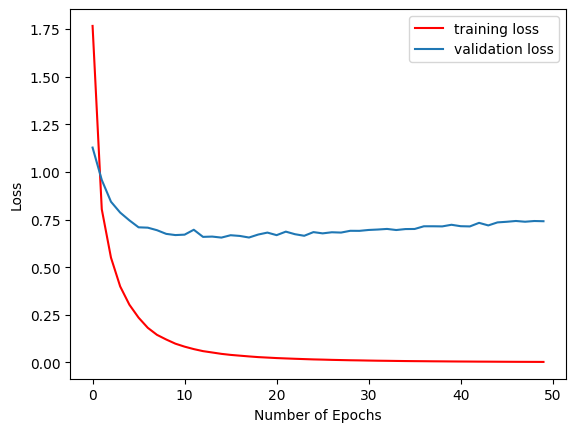

In [ ]:
import matplotlib.pyplot as plt

plt.plot(hist.history['loss'],'r',label='training loss')
plt.plot(hist.history['val_loss'],label='validation loss')
plt.xlabel('Number of Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Combine simple perceptron with resnet50 feature layers

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical

new_model = Sequential()
new_model.add(resnet_layers)
new_model.add(Dense(25, activation="sigmoid"))

new_model.layers[0].trainable=False
new_model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

hist = new_model.fit(
    x_train_preprocessed,
    to_categorical(y_train_raw),
    epochs=15,
    validation_data=(
        x_test_preprocessed, 
        to_categorical(y_test_raw)
    ), 
)

Epoch 1/15
 10/124 ━━━━━━━━━━━━━━━━━━━━ 1:05 573ms/step - accuracy: 0.0474 - loss: 3.5108

KeyboardInterrupt: 

In [ ]:
from sklearn.metrics import classification_report

y_pred = new_model.predict(x_test_features)

print("Classification report for - \n{}:\n{}\n".format(
    feature_model, classification_report(to_categorical(y_test_raw), y_pred)
))

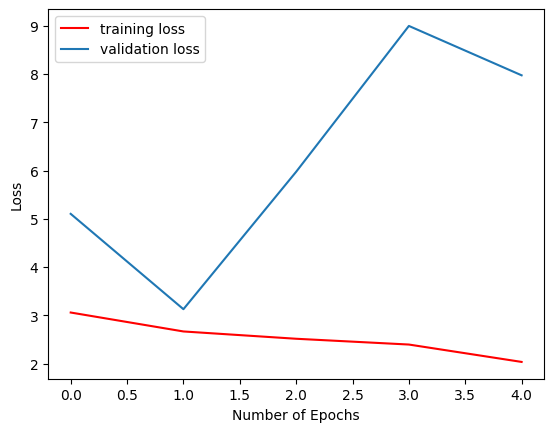

In [ ]:
import matplotlib.pyplot as plt

plt.plot(hist.history['loss'],'r',label='training loss')
plt.plot(hist.history['val_loss'],label='validation loss')
plt.xlabel('Number of Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Convert to .onnx (TODO)

In [ ]:
import numpy as np
import tensorflow as tf
import tf2onnx
import onnxruntime as rt
import onnx

input_signature = [tf.TensorSpec([1, 224, 224, 3], tf.double, name='x')]
# input_signature = [tf.TensorSpec([1, 64, 64, 3], tf.double, name='x')]
smallnet.output_names=['output']

onnx_model, _ = tf2onnx.convert.from_keras(smallnet, input_signature, opset=13)
onnx.save(onnx_model, "smallnet_groceries_224_224_3.onnx")
# onnx.save(onnx_model, "smallnet_cifar10_64_64_3.onnx")

session = rt.InferenceSession("smallnet_groceries_224_224_3.onnx", providers=["CPUExecutionProvider"])
# session = rt.InferenceSession("smallnet_cifar10_64_64_3.onnx", providers=["CPUExecutionProvider"])
input_name = session.get_inputs()[0].name
np.argmax(session.run(None, {input_name: np.array([np.array(x_test)[20]])})[0][0])

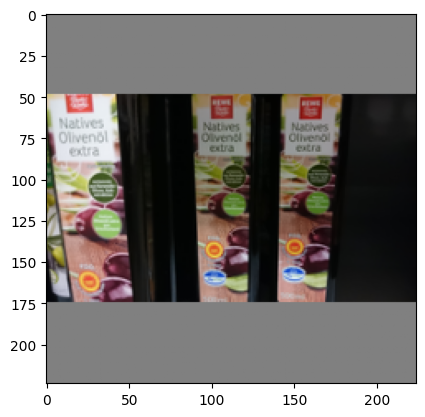

In [ ]:
import matplotlib.pyplot as plt

plt.imshow(x_test[20])
plt.show()